In [1]:
# import modules as usual
import os
import glob

import numpy as np

import pandas as pd
from pandas import DataFrame, Series

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import cv2

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# path of files
path_positive_1 = '../eskin_data/yamamoto/throw/'
path_negative_1 = '../eskin_data/yamamoto/others/'

path_positive_2 = '../eskin_data/zennra/throw/'
path_negative_2 = '../eskin_data/zennra/others/'

In [3]:
# extract the moment of throwing based on accel values
def extract_action(df):
    df = df.reset_index()
    
    mom_action = int((np.argmax(abs(df.accelX))+ np.argmax(abs(df.accelY))+ np.argmax(abs(df.accelZ)))/3)
    df = df.ix[mom_action-90:mom_action+90] 
    
    df.index = df.time
    df.drop(["time"], axis=1, inplace=True)
    
    return df.as_matrix()

In [4]:
def load_positive_data(path):
    path = os.path.join(path, '*.csv')
    files = glob.glob(path)
    
    X_positives = []
    
    for file_path in files:
        df = pd.read_csv(file_path, index_col=0)
        
        df = extract_action(df)
        
        X_positives.append(df)
        
    X_positives = np.array(X_positives)
    y_positives = np.ones(len(X_positives))
        
    return X_positives, y_positives

In [5]:
def load_negative_data(path, num_clip=100, random_state=71):
    np.random.seed(random_state)
    
    path = os.path.join(path, '*.csv')
    files = glob.glob(path)
    
    X_negatives = []
    
    for file_path in files:
        df = pd.read_csv(file_path, index_col=0)
        
        for i in range(num_clip):
            start = np.random.choice(range(len(df)-180))
            
            df_extracted = df.iloc[start:start+180].as_matrix()
            X_negatives.append(df_extracted)
        
    X_negatives = np.array(X_negatives)
    y_negatives = np.zeros(len(X_negatives))
        
    return X_negatives, y_negatives

In [6]:
def resize_matrix(X, size = (20, 20), flatten=False):
    X_resized = []
    
    for i in range(len(X)):
        X_ = X[i] /1.
        X_ = cv2.resize(X_, size, interpolation = cv2.INTER_LINEAR)
    
        if flatten == True: # True for XGBoost etc., False for CNN (Convolutional Newral Networks) 
            X_ = X_.ravel()
            
        X_resized.append(X_)
        
    X_resized = np.array(X_resized)
    
    return X_resized

In [7]:
def add_baseline(X, y, num_augment=1, max_abs_tilt=0.1, max_abs_intercept=20, random_state=71):
    np.random.seed(random_state)
    
    X_augmented = []
    y_augmented = []
    
    for j in range(num_augment): 
        
        for i in range(X.shape[0]):
            X_ = X[i].copy()
            y_ = y[i].copy()
           
    
            for col in range(X_.shape[1]-6):
                tilt = np.random.uniform(-max_abs_tilt, max_abs_tilt)
                intercept = np.random.uniform(-max_abs_intercept, max_abs_intercept)
                
                baseline = np.array(range(X_.shape[0])) * tilt + intercept
                
                X_[:,col] = X_[:,col] + baseline
                
            X_augmented.append(X_)
            y_augmented.append(y_)
                
    X_augmented = np.array(X_augmented)
    y_augmented = np.array(y_augmented)
    
    X = np.concatenate((X, X_augmented), axis=0)
    y = np.concatenate((y, y_augmented), axis=0)
    
    return X, y

In [8]:
def prepare_positive_data(path, size = (20, 20), flatten=True, is_augment=True, num_augment=10, max_abs_tilt=5, max_abs_intercept=20, random_state=71):
    X_positives, y_positives = load_positive_data(path)
    
    if is_augment == True:
        X_positives, y_positives = add_baseline(X_positives, y_positives, num_augment=num_augment, max_abs_tilt=max_abs_tilt, max_abs_intercept=max_abs_intercept, random_state=random_state)
        
    X_positives = resize_matrix(X_positives, flatten=flatten)
    
    return X_positives, y_positives


def prepare_negative_data(path, num_clip=500, size = (20, 20), flatten=True, is_augment=True, num_augment=10, max_abs_tilt=5, max_abs_intercept=20, random_state=71):
    X_negatives, y_negatives = load_negative_data(path, num_clip=num_clip, random_state=random_state)
    
    if is_augment == True:
        X_negatives, y_negatives = add_baseline(X_negatives, y_negatives, num_augment=num_augment, max_abs_tilt=max_abs_tilt, max_abs_intercept=max_abs_intercept, random_state=random_state)
        
    X_negatives = resize_matrix(X_negatives, flatten=flatten)
    
    return X_negatives, y_negatives

In [9]:
def scan_evaluate(clf, path, size = (20, 20), flatten=True):
    df = pd.read_csv(path, index_col=0)
    X_windows = []
    
    for i in range(df.shape[0]-180):
        X_window = df.iloc[i:i+180].as_matrix()
        X_windows.append(X_window)
        
    X_windows = np.array(X_windows)
    X_windows = resize_matrix(X_windows, size = size, flatten=flatten)
    
        
    probabilities = clf.predict_proba(X_windows)[:,1]
        
    plt.plot([x/60 for x in range(df.shape[0]-180)], probabilities)
    plt.xlabel("sec")
    plt.ylabel("probability")
    plt.ylim(0,1)
    plt.show()

In [10]:
# 1人目（山本）のモーションデータをData Augmentationありで読み込む
X_positives_1, y_positives_1 = prepare_positive_data(path_positive_1, is_augment=True, max_abs_tilt=5.0, num_augment=10)
X_negatives_1, y_negatives_1 = prepare_negative_data(path_negative_1, is_augment=False)

X_1_aug = np.concatenate((X_positives_1, X_negatives_1), axis=0)
y_1_aug = np.concatenate((y_positives_1, y_negatives_1), axis=0)

# 1人目（山本）のモーションデータをData Augmentationなしで読み込む
X_positives_1, y_positives_1 = prepare_positive_data(path_positive_1, is_augment=False)
X_negatives_1, y_negatives_1 = prepare_negative_data(path_negative_1, is_augment=False)

X_1 = np.concatenate((X_positives_1, X_negatives_1), axis=0)
y_1 = np.concatenate((y_positives_1, y_negatives_1), axis=0)


# 2人目（武井氏）のモーションデータをData Augmentationありで読み込む
X_positives_2, y_positives_2 = prepare_positive_data(path_positive_2, is_augment=True, max_abs_tilt=5.0, num_augment=10)
X_negatives_2, y_negatives_2 = prepare_negative_data(path_negative_2, is_augment=False)

X_2_aug = np.concatenate((X_positives_2, X_negatives_2), axis=0)
y_2_aug = np.concatenate((y_positives_2, y_negatives_2), axis=0)

# 2人目（武井氏）のモーションデータをData Augmentationなしで読み込む
X_positives_2, y_positives_2 = prepare_positive_data(path_positive_2, is_augment=False)
X_negatives_2, y_negatives_2 = prepare_negative_data(path_negative_2, is_augment=False)

X_2 = np.concatenate((X_positives_2, X_negatives_2), axis=0)
y_2 = np.concatenate((y_positives_2, y_negatives_2), axis=0)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


In [11]:
# それぞれのサイズを確認する
print(X_1_aug.shape, y_1_aug.shape)
print(X_1.shape, y_1.shape)

print(X_2_aug.shape, y_2_aug.shape)
print(X_2.shape, y_2.shape)

((3100, 400), (3100,))
((2100, 400), (2100,))
((2001, 400), (2001,))
((1091, 400), (1091,))


('Without Data Augmentation of train data, ROC-AUC: ', 0.98363736263736257)


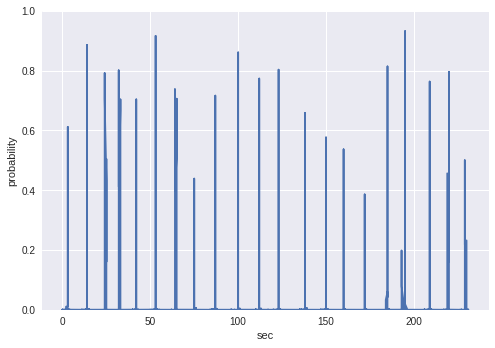

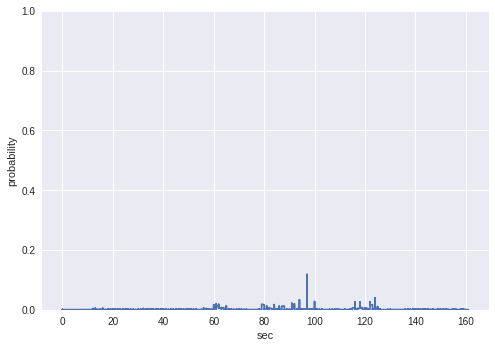

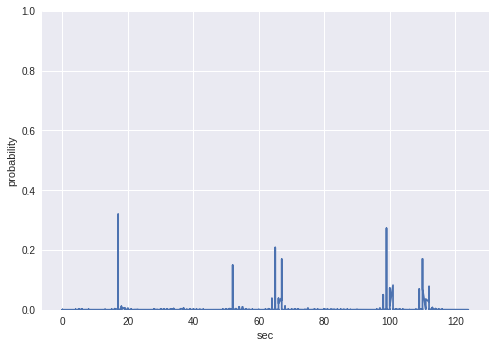

('With Data Augmentation of train data, ROC-AUC: ', 0.92542857142857149)


In [12]:
# 山本データで学習して、武井データに対して予測を行う。やや低下が見られたが依然として良好。
# もう一方のfoldで大きなゲインが得られたことを考えるとトータルでは分類性能向上しているか。
clf_xgb = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7, 
                        gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3, 
                        min_child_weight=1, missing=None, n_estimators=100, nthread=-1, 
                        objective='binary:logistic', reg_alpha=0, reg_lambda=1, 
                        scale_pos_weight=1, seed=0, silent=True, subsample=0.7)

clf_xgb.fit(X_1, y_1)
probs = clf_xgb.predict_proba(X_2)[:,1]
score = roc_auc_score(y_2, probs)
print("Without Data Augmentation of train data, ROC-AUC: ", score)

# 時系列データをスキャンしてprobabilityの時間変化を可視化する
scan_evaluate(clf_xgb, "../eskin_data/zennra_throw.csv", flatten=True)
scan_evaluate(clf_xgb, "../eskin_data/zennra/others/zennra_radiotaiso.csv", flatten=True)
scan_evaluate(clf_xgb, "../eskin_data/zennra/others/zennra_ebikanix.csv", flatten=True)

clf_xgb.fit(X_1_aug, y_1_aug)
probs = clf_xgb.predict_proba(X_2)[:,1]
score = roc_auc_score(y_2, probs)
print("With Data Augmentation of train data, ROC-AUC: ", score)

In [13]:
# 武井データで学習して、山本データに対して予測を行う。顕著な改善効果が認められた。
clf_xgb = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7, 
                        gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3, 
                        min_child_weight=1, missing=None, n_estimators=100, nthread=-1, 
                        objective='binary:logistic', reg_alpha=0, reg_lambda=1, 
                        scale_pos_weight=1, seed=0, silent=True, subsample=0.7)

clf_xgb.fit(X_2, y_2)
probs = clf_xgb.predict_proba(X_1)[:,1]
score = roc_auc_score(y_1, probs)
print("Without Data Augmentation of train data, ROC-AUC: ", score)

clf_xgb.fit(X_2_aug, y_2_aug)
probs = clf_xgb.predict_proba(X_1)[:,1]
score = roc_auc_score(y_1, probs)
print("With Data Augmentation of train data, ROC-AUC: ", score)

('Without Data Augmentation of train data, ROC-AUC: ', 0.83818499999999996)
('With Data Augmentation of train data, ROC-AUC: ', 0.98306000000000004)
